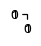

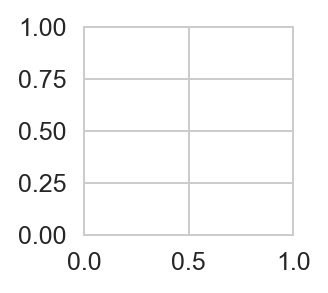

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.subplots(1,1,figsize=(1e-5, 1e-5))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('whitegrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass, NNAlignEFTwoStage
from src.datasets import NNAlignDataset
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import binomtest
plt.subplots(1,1,figsize=(1.5,1.5))
sns.set_palette('tab10', 6)

In [18]:
train_1 = pd.read_csv('../data/copy_rsync/250130_MHCI_structure_train_900k_fixed_partitions.csv')
test_1 = pd.read_csv('../data/copy_rsync/250213_MHCI_structure_test_79305_REFIXED_OVERLAP.csv')
train_2 = pd.read_csv('../data/copy_rsync/HLA_DR_subsample_all_partitions_922k.csv')
test_2 = pd.read_csv('../data/copy_rsync/HLA_DR_500K_unseen_sequence_test_set.csv')

# features analysis // summaries

In [32]:
def get_mean_feat(x):
    return np.mean([float(z) for z in x.split(',')])
fcols = ['rsa', 'disorder', 'pq3_H', 'pq3_E', 'pq3_C']
for c in fcols:
    train_1[f'mean_{c}'] = train_1[c].apply(get_mean_feat)
    test_1[f'mean_{c}'] = test_1[c].apply(get_mean_feat)
    train_2[f'mean_{c}'] = train_2[c].apply(get_mean_feat)
    test_2[f'mean_{c}'] = test_2[c].apply(get_mean_feat)

In [70]:
display(train_1.groupby('target').agg(count=('sequence','count')))
display(test_1.groupby('target').agg(count=('sequence','count')))
display(train_2.groupby('target').agg(count=('sequence','count')))
display(test_2.groupby('target').agg(count=('sequence','count')))

,count
target,
0.0,855363
1.0,44637


,count
target,
0.0,76334
1.0,2971


,count
target,
0.0,829455
1.0,93370


,count
target,
0.0,474159
1.0,25841


## Class 1 

In [66]:
from scipy.stats import ttest_ind
gb = train_1.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))
pos = train_1.query('target==1')
neg = train_1.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.398  0.157         0.257  0.368      0.321  0.350      0.131   
1.0       0.353  0.151         0.176  0.321      0.397  0.372      0.144   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.207      0.548  0.320  
1.0     0.225      0.459  0.312

rsa 	 0.0
disorder 	 0.0
pq3_H 	 0.0
pq3_E 	 3.582307042687383e-35
pq3_C 	 0.0


In [67]:
from scipy.stats import ttest_ind
gb = test_1.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))
pos = test_1.query('target==1')
neg = test_1.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.397  0.158         0.258  0.369      0.322  0.350      0.129   
1.0       0.356  0.152         0.181  0.324      0.389  0.369      0.145   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.206      0.549  0.321  
1.0     0.225      0.465  0.310

rsa 	 2.158260825144328e-46
disorder 	 5.757291651424848e-36
pq3_H 	 1.2033159967963686e-22
pq3_E 	 6.415784724252607e-05
pq3_C 	 7.670853581036333e-46


## Class 2

In [68]:
from scipy.stats import ttest_ind
gb = train_2.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))
pos = train_2.query('target==1')
neg = train_2.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.393  0.142         0.239  0.350      0.332  0.326      0.133   
1.0       0.366  0.130         0.157  0.302      0.294  0.321      0.216   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.191      0.535  0.291  
1.0     0.232      0.490  0.257

rsa 	 0.0
disorder 	 0.0
pq3_H 	 2.4448492072216625e-250
pq3_E 	 0.0
pq3_C 	 0.0


In [69]:
from scipy.stats import ttest_ind
gb = test_2.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))

pos = test_2.query('target==1')
neg = test_2.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.393  0.143         0.240  0.351      0.331  0.326      0.132   
1.0       0.369  0.131         0.168  0.310      0.303  0.324      0.202   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.191      0.536  0.292  
1.0     0.228      0.494  0.262

rsa 	 4.4000763491926746e-178
disorder 	 2.3368702096341803e-280
pq3_H 	 1.3588137776530028e-41
pq3_E 	 0.0
pq3_C 	 1.0003808557785946e-136


# results

In [2]:
DD='../output/250218_StructAll_results_REREDONE/'
%ls ../output/250218_StructAll_results_REREDONE| head -n 3

HLA-DR_ensemble_test_baseline.csv
HLA-DR_ensemble_test_disorder_only.csv
HLA-DR_ensemble_test_mean_struct.csv


In [3]:
def get_name(fn):
    if 'ensemble_test' in fn:
        return fn.split('ensemble_test_')[1].replace('.csv','').split('_per_HLA')[0]
    elif 'valid' in fn:
        return fn.split('valid_')[1].replace('.csv','').split('_per_HLA')[0]

def read_result(fn):
    name = get_name(fn)
    return pd.read_csv(fn).assign(model=name)
    
def get_binompval(k,n, alt="greater"):
    return binomtest(k,n, alternative=alt).pvalue
    
def do_binom(df):
    bs = df.query('model=="baseline"').set_index('MHC')[['auc','auc01','ppv']]
    n = len(bs)
    results = []
    for model in [x for x in df.model.unique() if x !="baseline"]:
        tmp = df.query('model==@model').set_index('MHC')
        ks = (tmp[['auc','auc01','ppv']] > bs).sum()
        results.append(pd.DataFrame(ks.apply(get_binompval, n=n), columns=[model]).T)
    return pd.concat(results).rename(columns={k:f'{k}_pval' for k in ['auc','auc01','ppv']}).rename(index={'baseline':'Baseline', 'mean_struct':'Mean',
                 'pos_struct':'All', 'rsa_only':'RSA', 
                 'disorder_only':'Disorder', 'pq3_only':'pq3'}).loc[['Mean', 'All', 'RSA', 'Disorder', 'pq3']]

In [4]:
def make_box(df, figsize=(12,7), saturation=0.8, alpha=0.8, 
             width=0.8, size=1, swarm=False, fill=True, fn=None, od='../output/250218_StructAll_results_REREDONE/'):
    # df stuff
    fs = 16
    fw = 'semibold'
    pvals = do_binom(df)
    sigs = pvals.applymap(lambda x: 'ns' if x > 0.05 else 
                                    '****' if x <= 0.0001 else 
                                    '***' if x <= 0.001 else 
                                    '**' if x <= 0.01 else 
                                    '*')
    sigs = pd.concat([pd.DataFrame({'auc_pval':'None', 'auc01_pval':'None', 'ppv_pval':'None'}, 
                                   index=['baseline']),
                     sigs])
    tmp = df.melt(id_vars=['model'], value_vars=['auc','auc01','ppv'])
    tmp.replace({'baseline':'Baseline', 'mean_struct':'Mean',
                 'pos_struct':'All', 'rsa_only':'RSA', 
                 'disorder_only':'Disorder', 'pq3_only':'pq3',
                 'auc':'AUC', 'auc01':'AUC01', 'ppv':'PPV'}, inplace=True)
    # Make boxplot
    palette=sns.color_palette('tab10', 6)
    hue_order = ['Baseline']+list(pvals.index)#,'Mean','All','RSA', 'Disorder', 'pq3']
    fig, ax = plt.subplots(1,1, figsize=figsize)

    ax.set_yticks(np.arange(0., 1.1, 0.1))
    ax.set_ylim([0.15, 1.05])
    sns.boxplot(tmp, y='value', x='variable', hue='model', ax=ax, saturation=saturation,
                hue_order=hue_order, width=width, fill=fill, dodge=True, gap=0.1)

    for i,p in enumerate([x for x in ax.patches if type(x).__name__=='PathPatch']):
        p.set_alpha(alpha)

    # Make Swarm
    if swarm:
        sns.swarmplot(tmp, y='value', x='variable', hue='model', ax=ax, dodge=True, size=size,
                      alpha=min(1,alpha*2), legend=False)

    # Significance levels
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines = ax.get_lines()
    lines_per_box = 6 if fill else 7
    for i, median in enumerate(lines[4:len(lines):lines_per_box]):
        if i in [0, 1, 2]:continue#0, 0+6, 0+12]: continue
        else:
            x, y = (data.mean() for data in median.get_data())
            # updating seaborn changed the order in which the fucking boxes are made
            # now the index is [0, 1, 2] = [hue_0_x0, hue0_x1, hue0_x2]
            ax.text(x, y=1.025,s=sigs.T.melt().iloc[i,1], 
                    horizontalalignment='center', verticalalignment='center',
                    fontweight=fw, fontsize=fs)

    # Formatting
    ax.set_xlabel('Metric', fontweight=fw, fontsize=fs)
    ax.set_ylabel('Value', fontweight=fw, fontsize=fs)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs)
    ax.legend(title=None,prop={'weight':fw,'size':fs}, loc='lower left')

    ax.grid(True, axis='y', which='major', linestyle='-', linewidth=0.7)
    ax.grid(False, which='minor')
    if fn is not None:
        fig.savefig(f'{od}{fn}.png', dpi=300, bbox_inches='tight')
        pvals.to_csv(f'{od}{fn}_pvals.csv')
    return pvals, sigs, ax

In [5]:
alpha=0.7
size=2.5
figsize=(18,10)
width=.8
saturation=1
swarm=True
fill=False
fn=None
mhc1_kcv_pvs, mhc1_kcv_sgs,_ = make_box(mhc1_kcv, figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_kcv_sgs)

NameError: name 'mhc1_kcv' is not defined

## Class I

### KCV (I)

,auc_pval,auc01_pval,ppv_pval
Mean,1.000000,1.000000,1.000000
All,0.994968,0.162239,0.578051
RSA,0.083722,0.083722,0.942766
Disorder,0.500000,0.162239,0.500000
pq3,0.024117,0.002768,0.975883


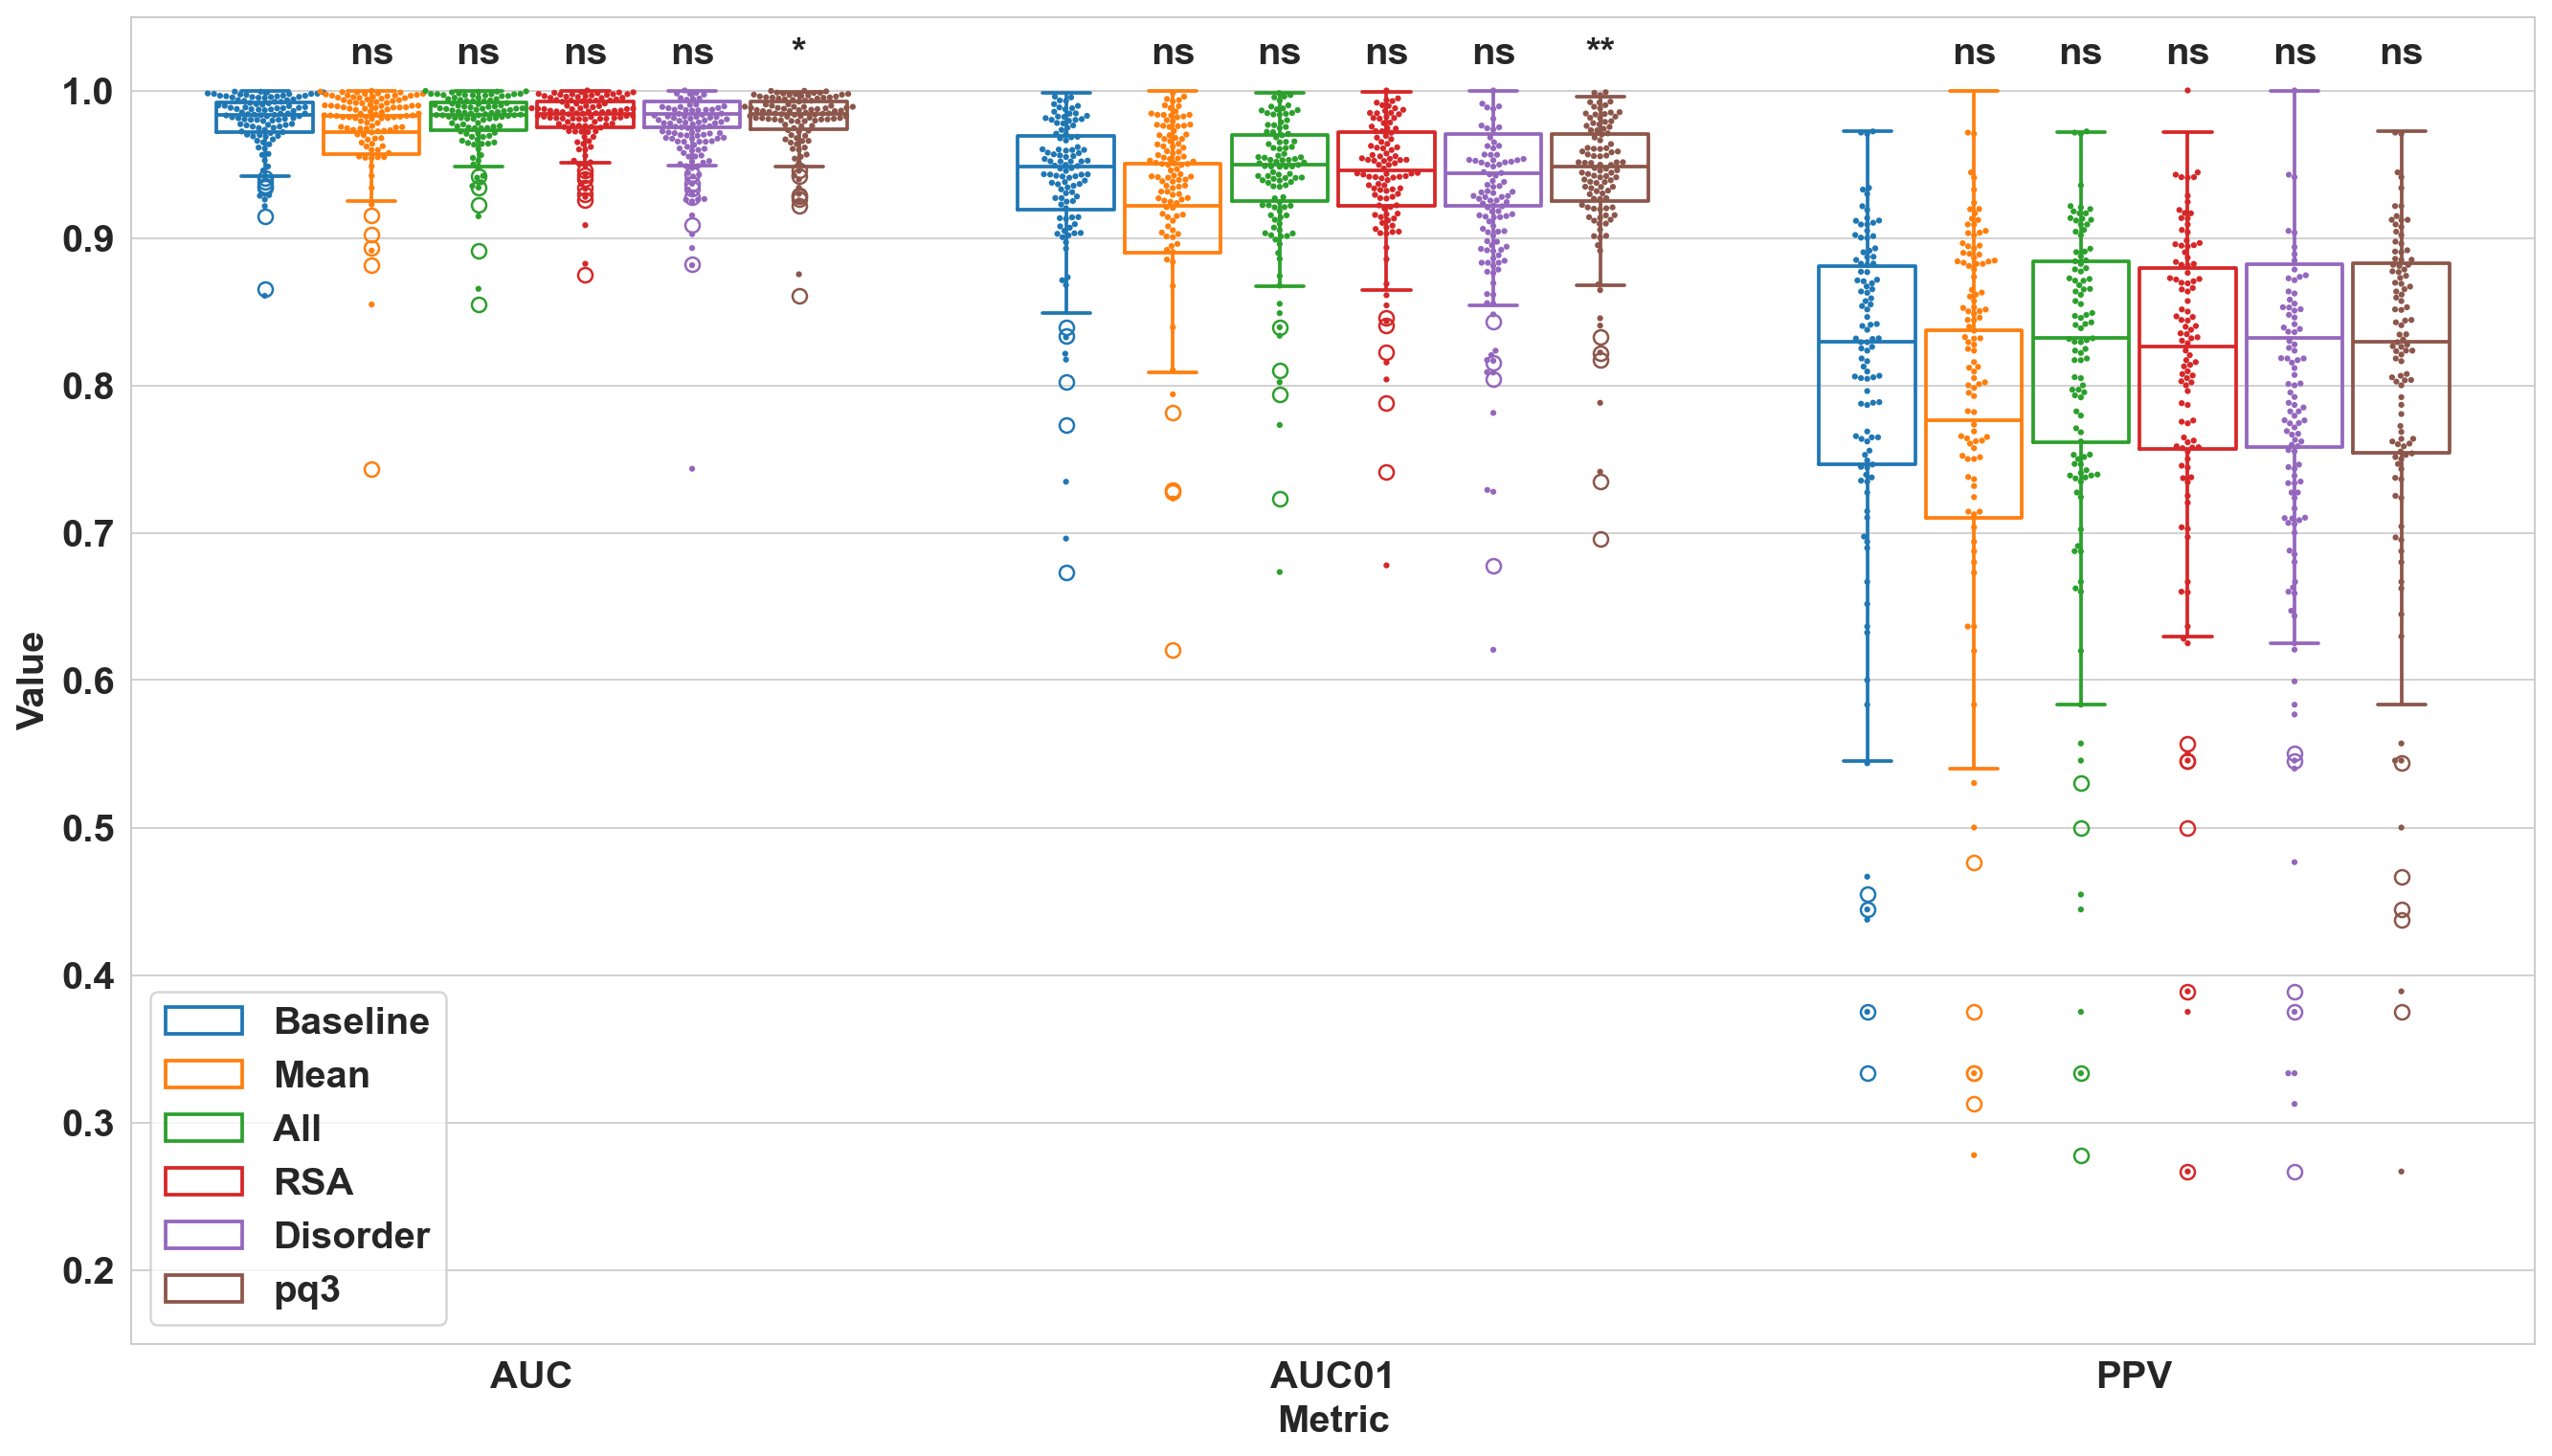

In [6]:
files = glob.glob(f'{DD}*MHCI_valid*')
fn='MHC1_KCV'
mhc1_kcv = pd.concat([read_result(f) for f in files])
mhc1_kcv_pvs, mhc1_kcv_sgs,_ = make_box(mhc1_kcv, figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_kcv_pvs)

### Test set (I)

,auc_pval,auc01_pval,ppv_pval
Mean,1.000000,1.000000,1.000000
All,0.087643,0.054428,0.990671
RSA,0.866094,0.356115,0.999995
Disorder,0.548921,0.730709,0.999995
pq3,0.945572,0.730709,0.982209


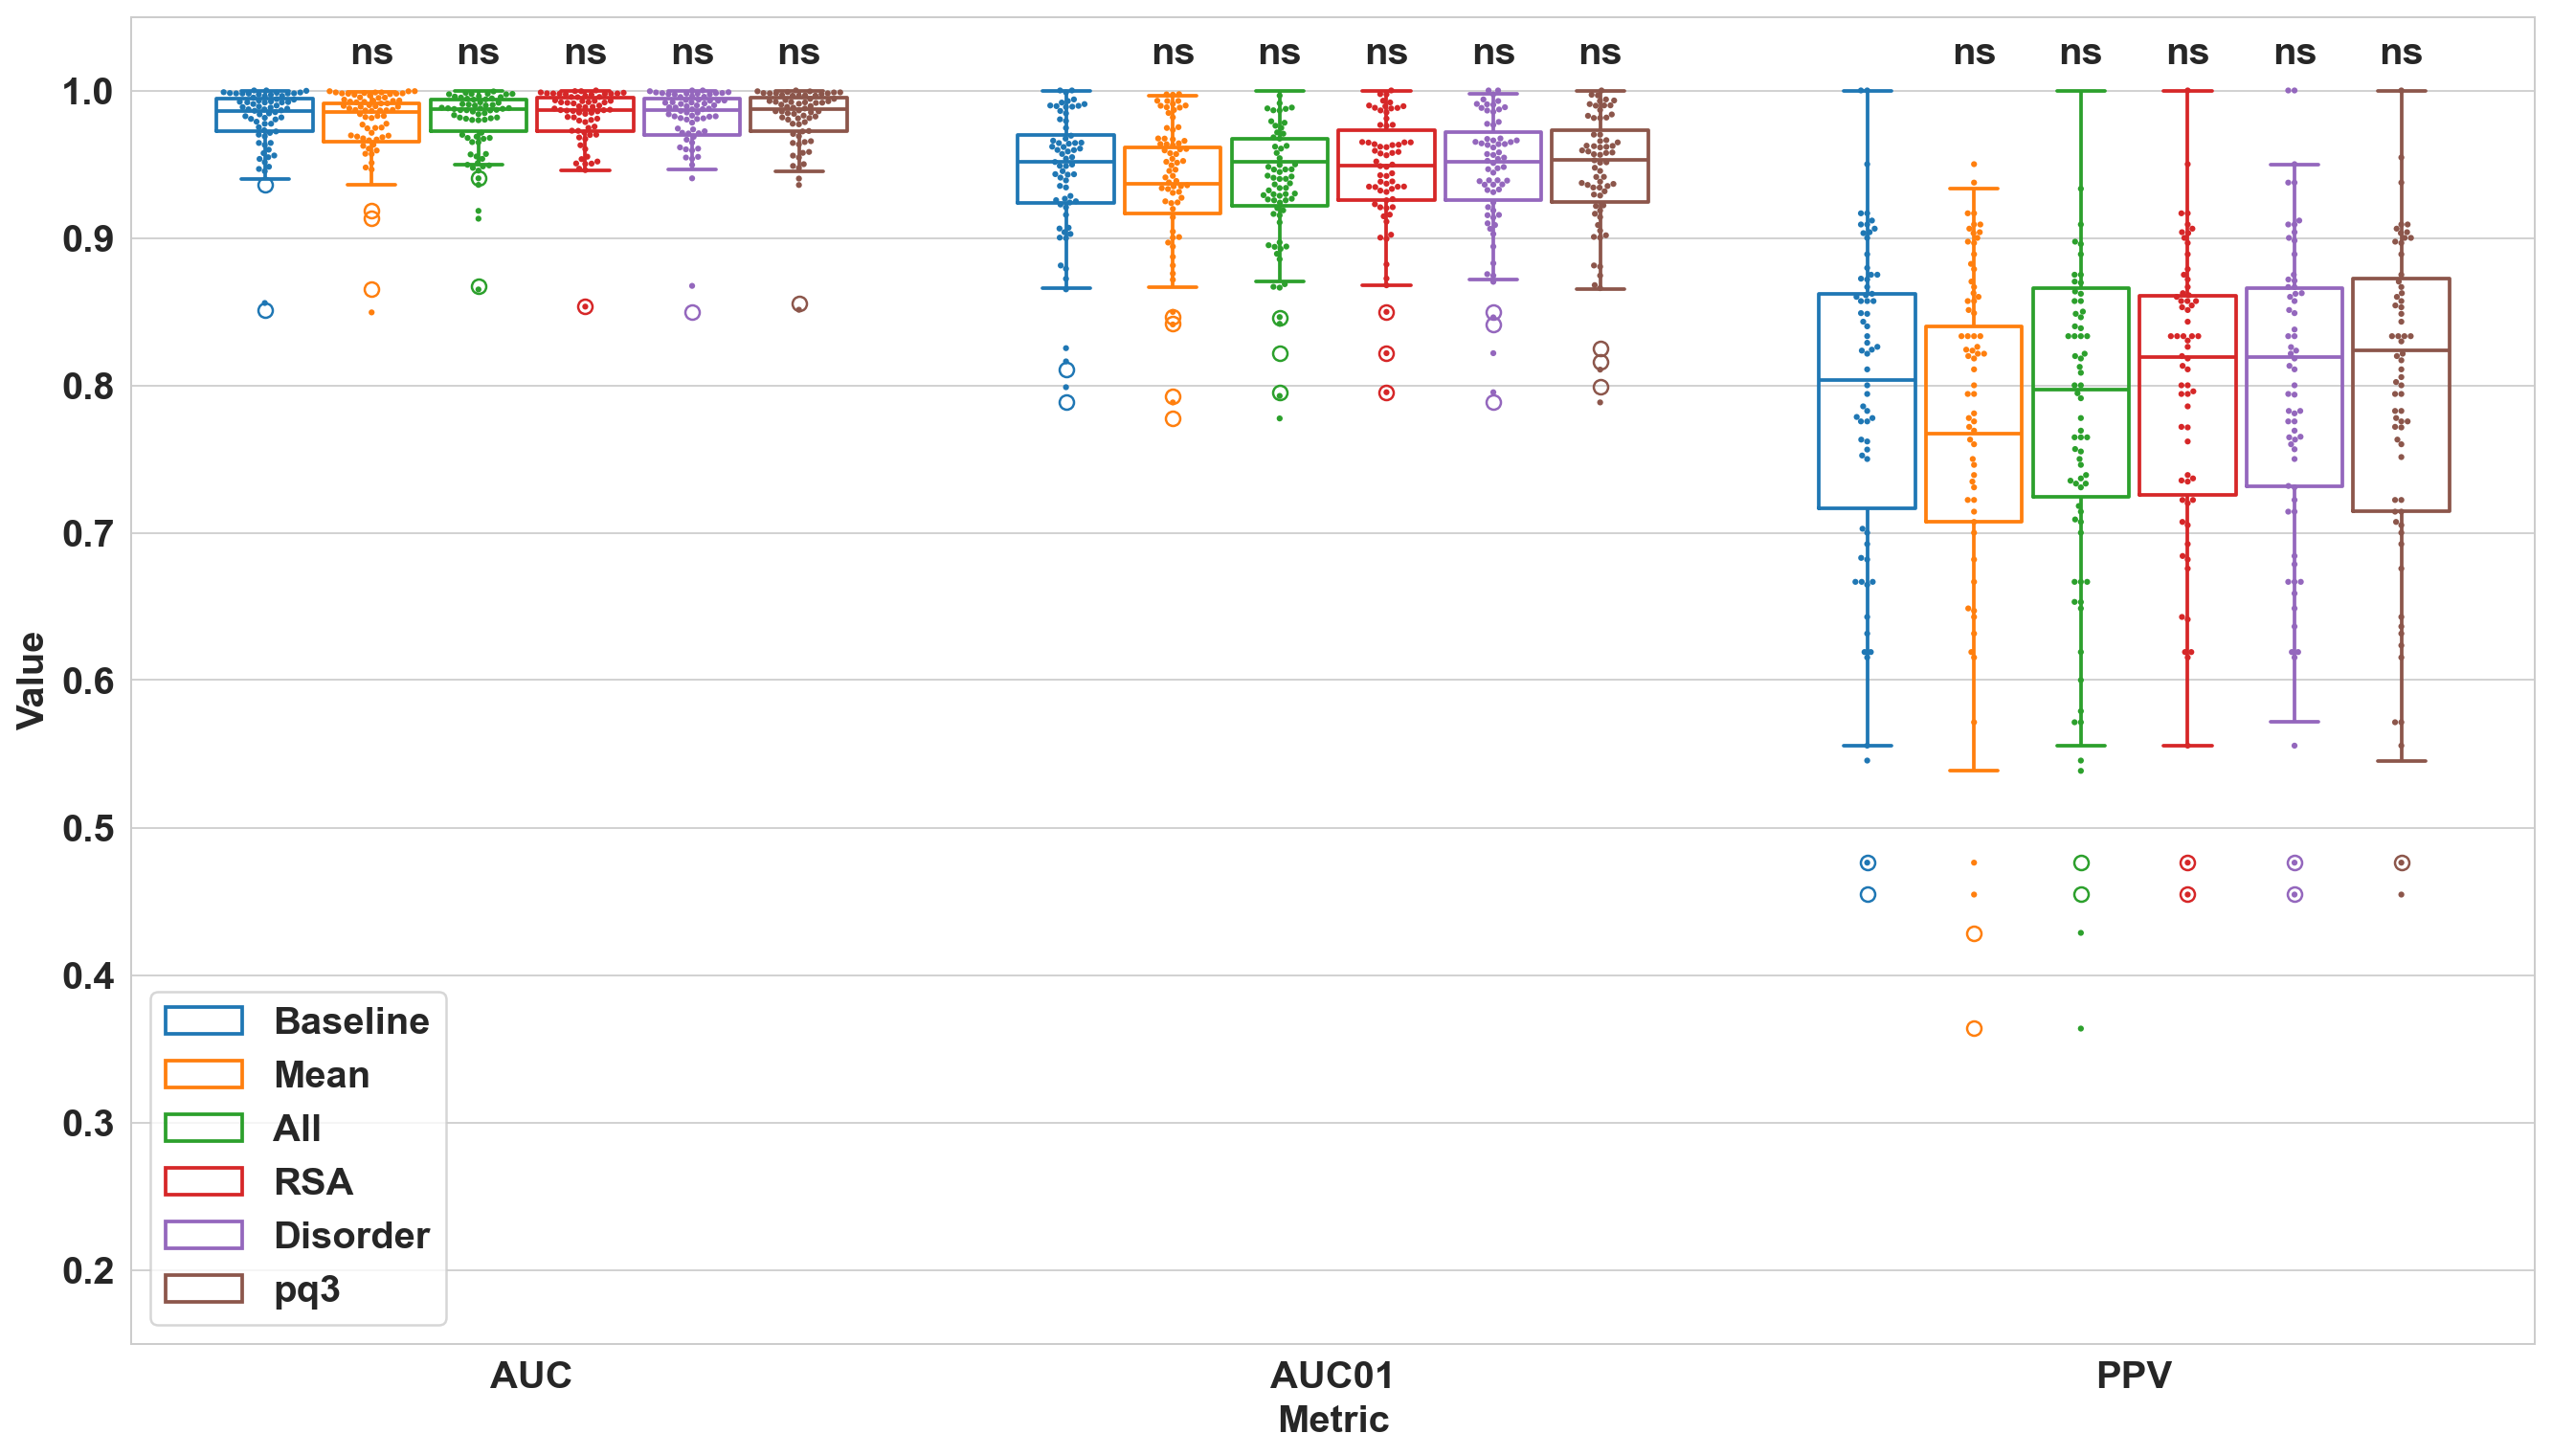

In [8]:
files = glob.glob(f'{DD}*MHCI_ensemble_test*')
fn='MHC1_Test'
mhc1_test = pd.concat([read_result(f) for f in files])
do_binom(mhc1_test)
mhc1_test_pvs, mhc1_test_sgs,_ = make_box(mhc1_test,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_test_pvs)

## Class II

### KCV (II)

In [14]:
glob.glob(f'{DD}*DR_valid*.csv')

['../output/250218_StructAll_results_REREDONE/HLA-DR_valid_mean_struct_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_baseline_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_pq3_only_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_rsa_only_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_disorder_only_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_pos_struct_per_HLA_all_partitions_concat.csv']

,auc_pval,auc01_pval,ppv_pval
Mean,1.000000,1.000000,1.000000
All,0.000008,0.000008,0.003958
RSA,0.044215,0.044215,0.082075
Disorder,0.044215,0.321984,0.139978
pq3,0.001444,0.021779,0.021779


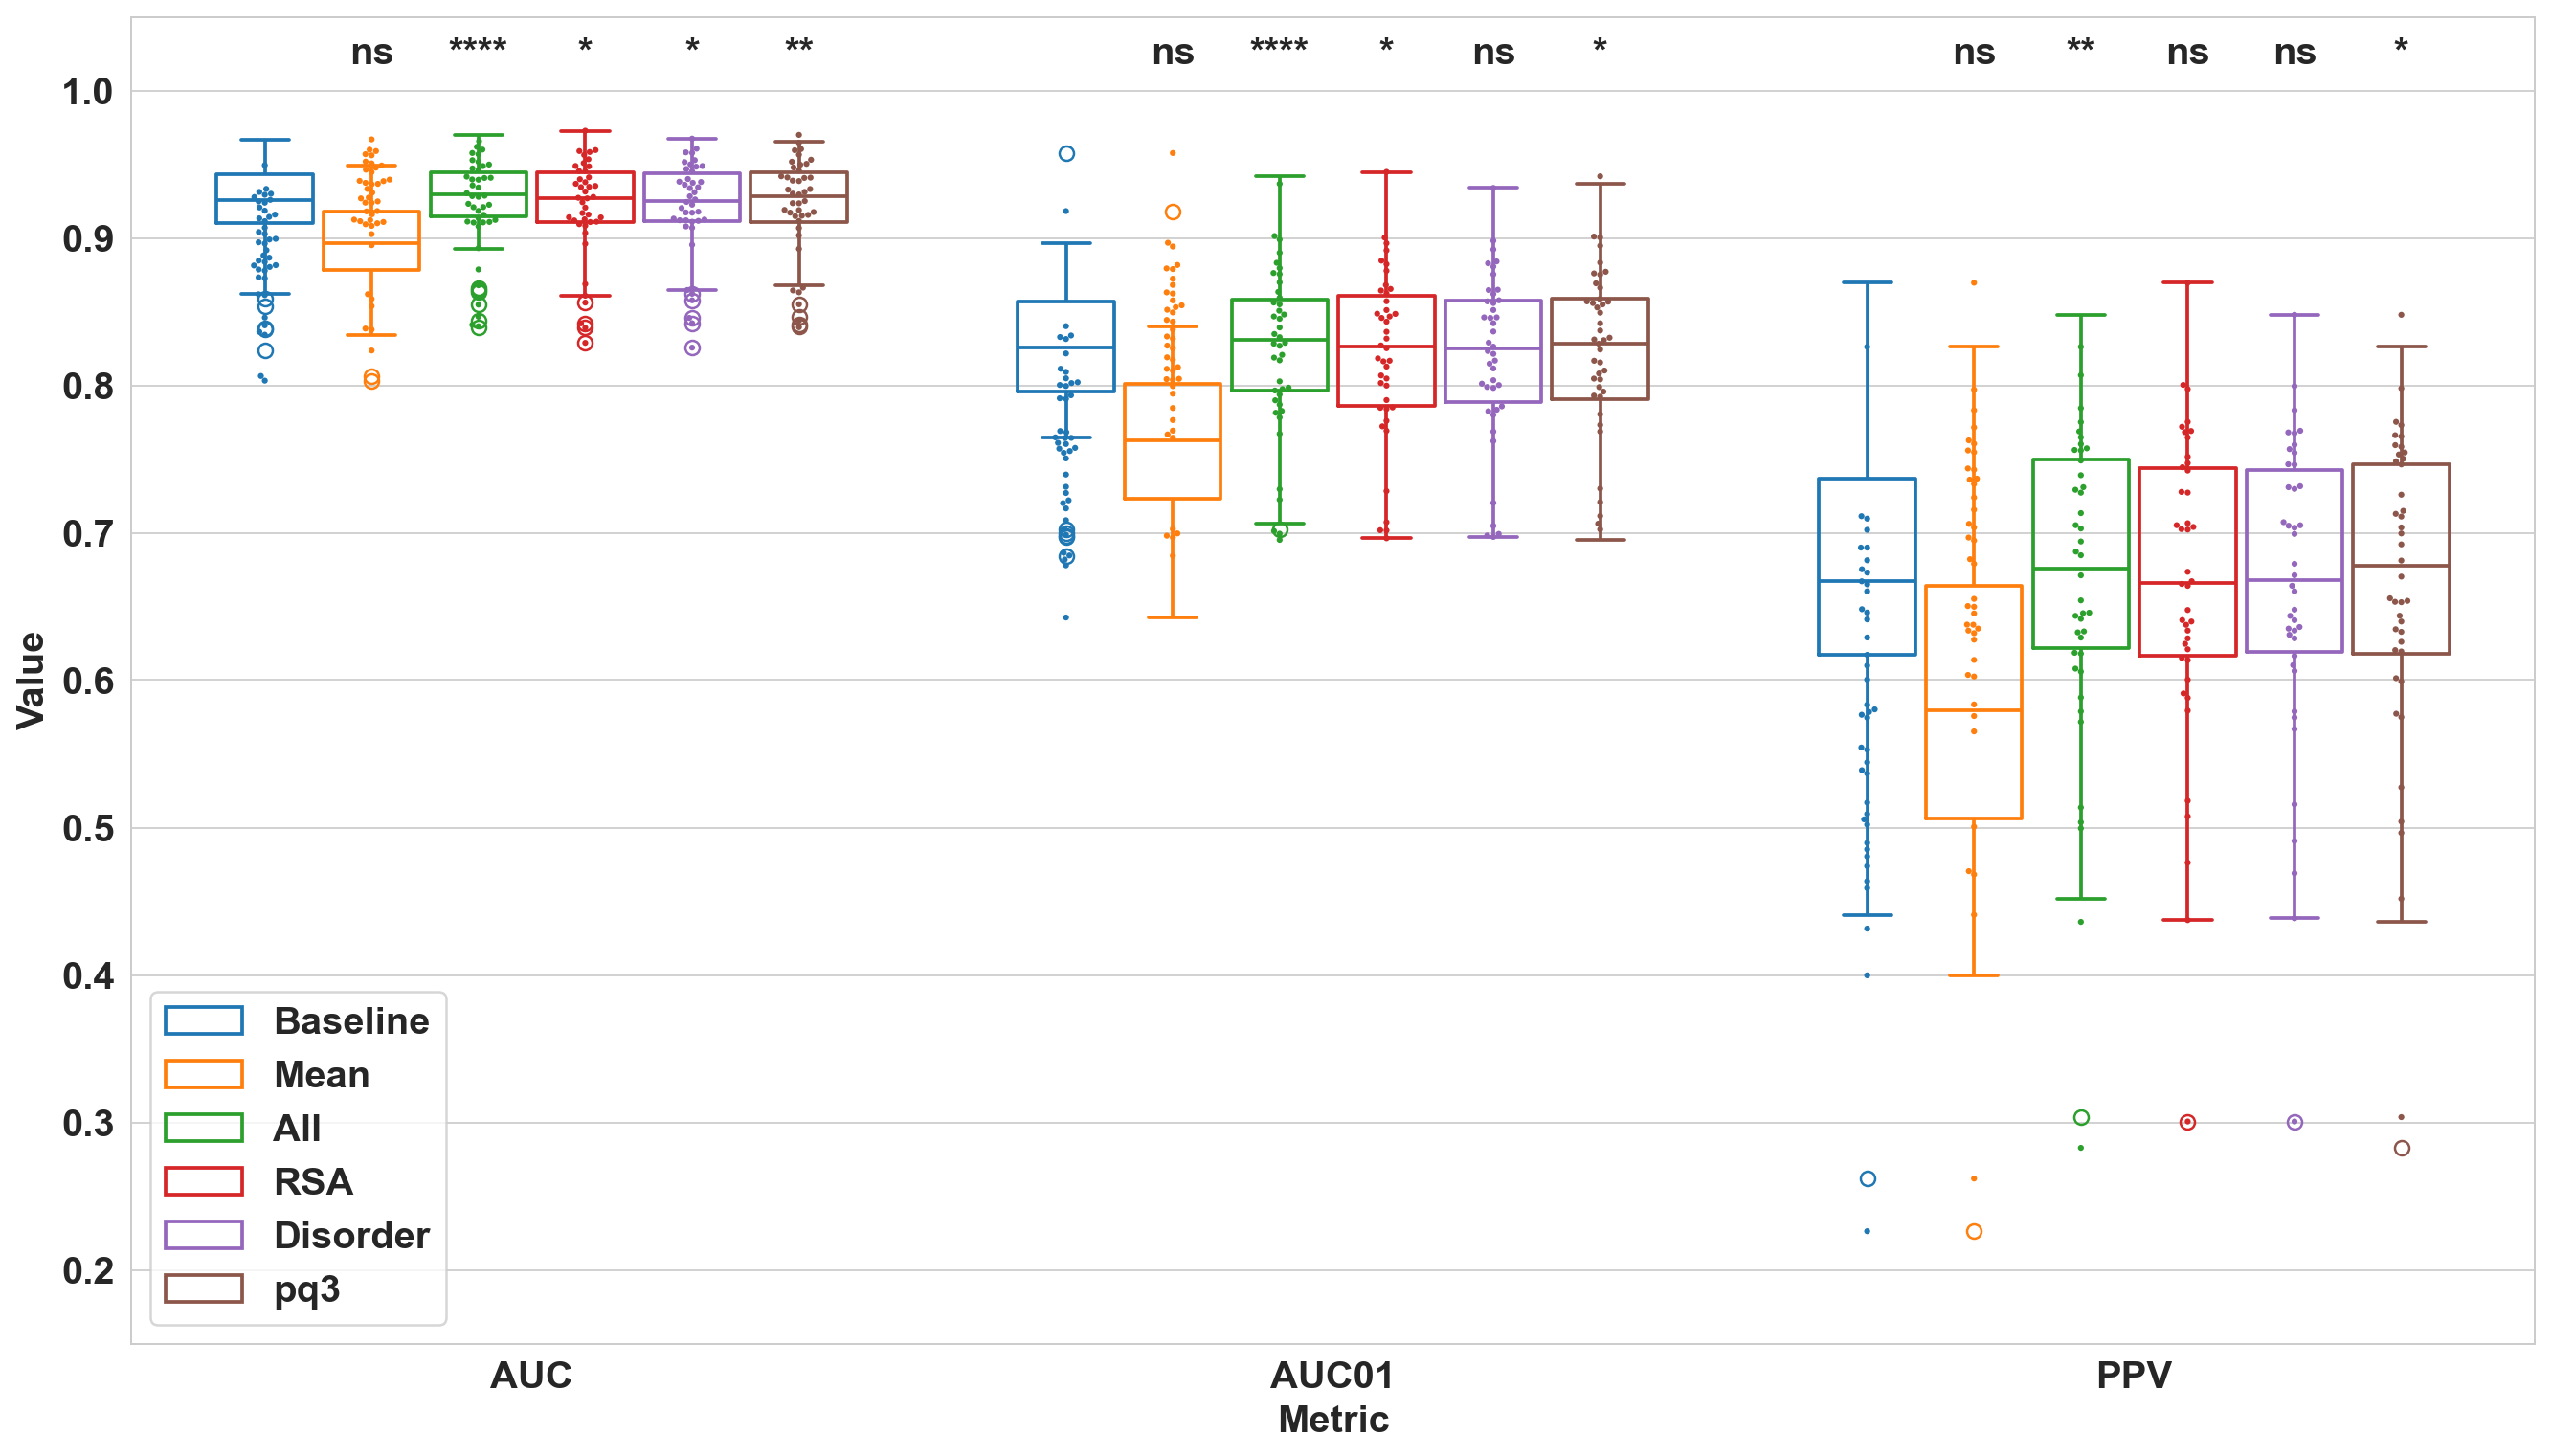

In [15]:
files = glob.glob(f'{DD}*DR_valid*.csv')
fn='HLA-DR_KCV'
mhc2_kcv = pd.concat([read_result(f) for f in files])
mhc2_kcv_pvs, mhc2_kcv_sgs,_ = make_box(mhc2_kcv,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc2_kcv_pvs)

### Test set (II)

,auc_pval,auc01_pval,ppv_pval
Mean,0.894488,1.000000,1.000000
All,0.058638,0.029792,0.029792
RSA,0.970208,0.733645,0.500000
Disorder,1.000000,1.000000,1.000000
pq3,0.266355,0.733645,0.500000


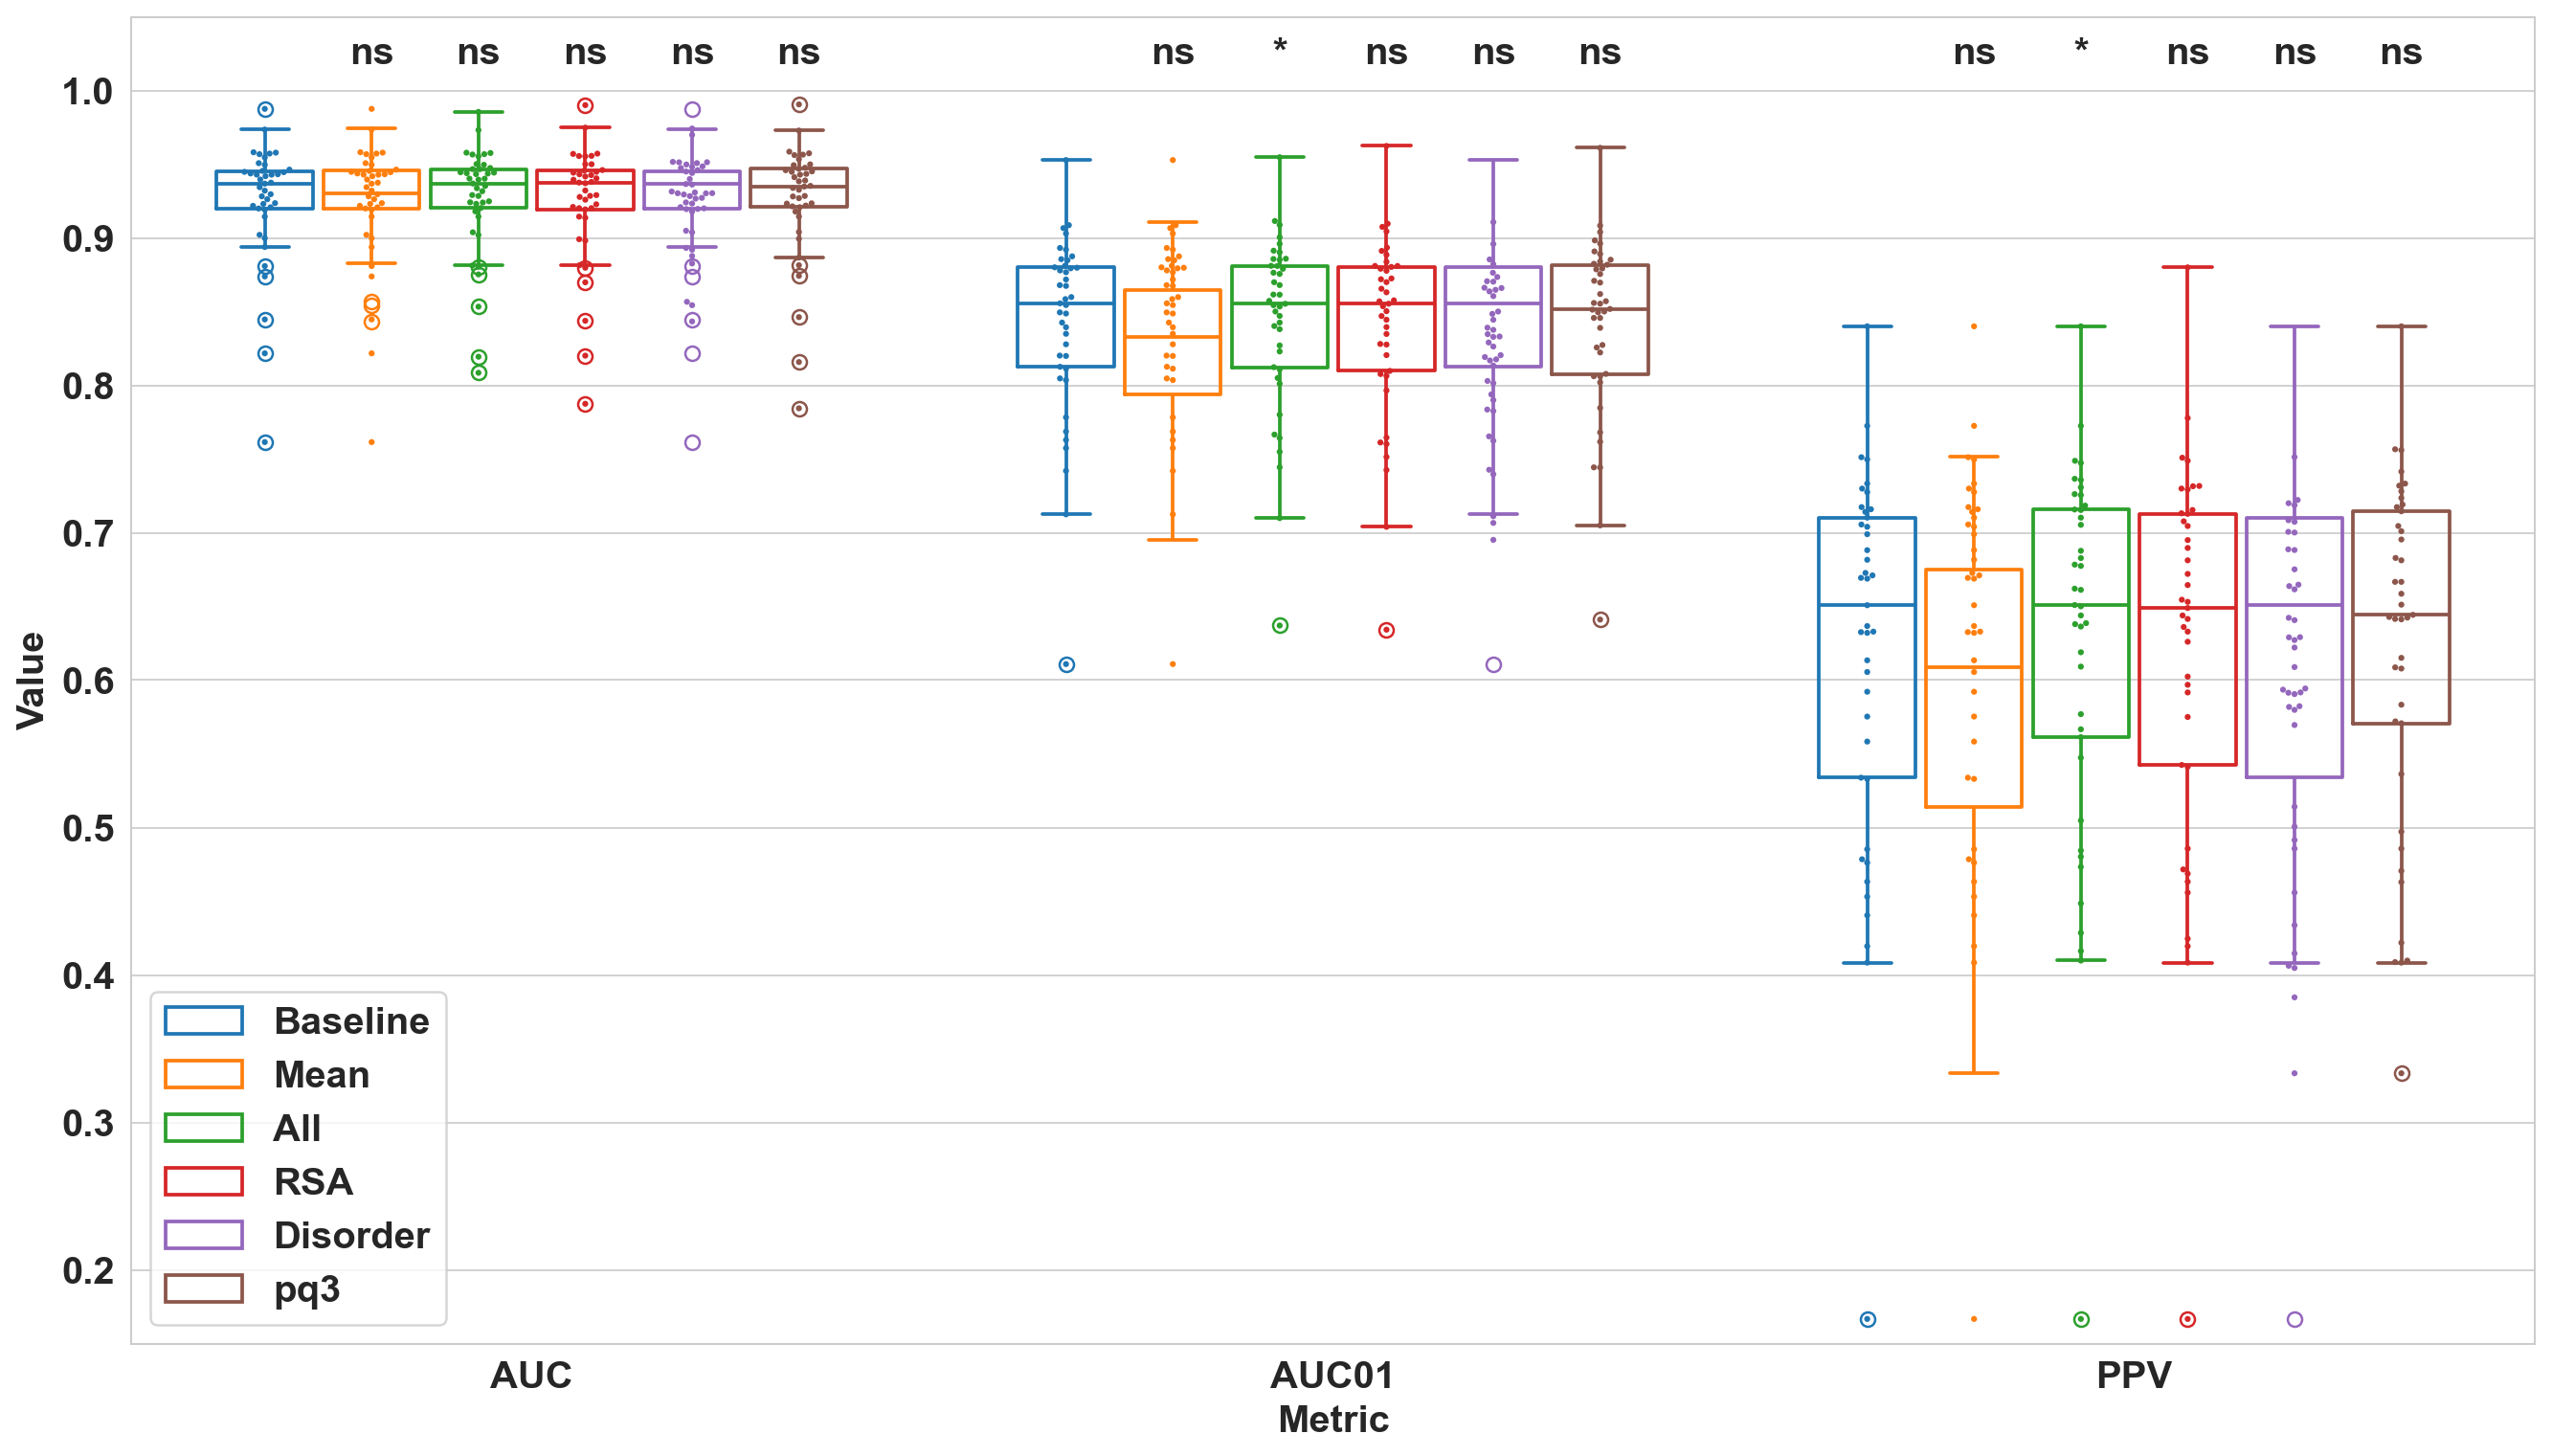

In [17]:
files = glob.glob(f'{DD}*DR_ensemble_test*.csv')
mhc2_test = pd.concat([read_result(f) for f in files])
fn='HLA-DR_Test'
do_binom(mhc2_test)
mhc2_test_pvs, mhc2_test_sgs, _ = make_box(mhc2_test,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc2_test_pvs)

## pvals and enrichment stuff

In [80]:
a=mhc2_kcv.query('model=="baseline"').set_index('MHC')[['auc', 'auc01', 'ppv']]
b=mhc2_kcv.query('model=="pos_struct"').set_index('MHC')[['auc', 'auc01', 'ppv']]
(b>a).query('auc01')

,auc,auc01,ppv
MHC,,,
DRB1_0101,True,True,True
DRB1_0102,True,True,True
DRB1_0103,True,True,True
DRB1_0301,True,True,True
DRB1_0302,True,True,True
DRB1_0401,True,True,True
DRB1_0403,False,True,False
DRB1_0404,True,True,False
DRB1_0407,True,True,False


In [81]:
# get enriched list (for Delta AUC01 > threshold) vs non enriched list
(b-a).query('auc01>2.5e-3').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_validset_delta_AUC01_2.5e-3_allele_list.txt', header=False, index=False)
(b>a).query('not auc01').reset_index()['MHC'].to_csv(f'{DD}NOT_ENRICHED_HLA_DR_validset_allele_list.txt', header=False, index=False)
(b>a).query('auc01').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_validset_all_delta_AUC01_allele_list.txt', header=False, index=False)

In [191]:
binomtest(26,41, alternative="greater")

BinomTestResult(k=26, n=41, alternative='greater', statistic=0.6341463414634146, pvalue=0.05863760297870613)

In [196]:
(d>c).apply(lambda x: binomtest(x.sum(), x.count(), alternative="greater").pvalue)

auc      0.058638
auc01    0.029792
ppv      0.029792
dtype: float64

In [82]:
c=mhc2_test.query('model=="baseline"').set_index('MHC')[['auc', 'auc01', 'ppv']]
d=mhc2_test.query('model=="pos_struct"').set_index('MHC')[['auc', 'auc01', 'ppv']]
(d>c).query('auc01')

,auc,auc01,ppv
MHC,,,
DRB1_0101,True,True,True
DRB1_0102,False,True,True
DRB1_0103,False,True,False
DRB1_0301,True,True,True
DRB1_0401,True,True,True
DRB1_0403,True,True,True
DRB1_0404,True,True,True
DRB1_0407,True,True,True
DRB1_0701,True,True,True


In [83]:
(d>c).query('auc01')

,auc,auc01,ppv
MHC,,,
DRB1_0101,True,True,True
DRB1_0102,False,True,True
DRB1_0103,False,True,False
DRB1_0301,True,True,True
DRB1_0401,True,True,True
DRB1_0403,True,True,True
DRB1_0404,True,True,True
DRB1_0407,True,True,True
DRB1_0701,True,True,True


In [220]:
len((d>c).query('auc01'))

27

In [84]:
# get enriched list (for Delta AUC01 > threshold) vs non enriched list
(d-c).query('auc01>2.5e-3').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt', header=False, index=False)
(d>c).query('not auc01').reset_index()['MHC'].to_csv(f'{DD}NOT_ENRICHED_HLA_DR_testset_allele_list.txt', header=False, index=False)
(d>c).query('auc01').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_all_delta_AUC01_allele_list.txt', header=False, index=False)

# ?

In [79]:
%wc -l $DD

UsageError: Line magic function `%wc` not found.


In [72]:
%ls $DD | grep enrich

enriched_HLA_DR_testset_all_delta_AUC01_allele_list.txt
enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt
enriched_HLA_DR_validset_all_delta_AUC01_allele_list.txt
enriched_HLA_DR_validset_delta_AUC01_2.5e-3_allele_list.txt


In [73]:
enrich_test = pd.read_csv(f'{DD}enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt')
enrich_kcv = pd.read_csv(f'{DD}enriched_HLA_DR_validset_delta_AUC01_2.5e-3_allele_list.txt')

In [78]:
%cat $DD/enriched_HLA_DR_validset_all_delta_AUC01_allele_list.txt



DRB1_0101
DRB1_0102
DRB1_0103
DRB1_0301
DRB1_0302
DRB1_0401
DRB1_0403
DRB1_0404
DRB1_0407
DRB1_0408
DRB1_0701
DRB1_0801
DRB1_0802
DRB1_0803
DRB1_0804
DRB1_0901
DRB1_1101
DRB1_1102
DRB1_1104
DRB1_1301
DRB1_1302
DRB1_1303
DRB1_1401
DRB1_1402
DRB1_1454
DRB1_1501
DRB1_1502
DRB1_1503
DRB1_1601
DRB3_0101
DRB3_0202
DRB3_0301
DRB4_0101
DRB5_0101
DRB5_0202


In [76]:
enrich_kcv

,DRB1_0101
0,DRB1_0102
1,DRB1_0103
2,DRB1_0301
3,DRB1_0302
4,DRB1_0401
5,DRB1_0407
6,DRB1_0408
7,DRB1_0701
8,DRB1_0801
9,DRB1_0802
